In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data

In [2]:
df = pd.read_csv('/content/ascs.csv', sep=';')
df.head()

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,24.07.18,24.08.18,3091.0,123.0,30,0.03780329990294403
1,354412280,Basic,Mercedes-Benz,35950,4,2015,16.08.18,07.10.18,3283.0,223.0,52,0.06792567773378008
2,349572992,Basic,Mercedes-Benz,11950,3,1998,16.07.18,05.09.18,3247.0,265.0,51,0.0816137973514013
3,350266763,Basic,Ford,1750,6,2003,20.07.18,29.10.18,1856.0,26.0,101,0.014008620689655173
4,355688985,Basic,Mercedes-Benz,26500,3,2014,28.08.18,08.09.18,490.0,20.0,12,0.04081632653061224


In [3]:
df.describe(percentiles = [0.01,0.05, 0.1,0.25,0.5,0.75, 0.95, 0.99])

,article_id,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days
count,7.832100e+04,78321.000000,78321.000000,78321.000000,78311.000000,78311.000000,78321.000000
mean,3.574869e+08,15067.655316,4.632117,2011.089465,2297.502522,93.469870,35.986262
std,5.076572e+06,16374.497606,2.354275,6.538395,6339.034423,228.025588,32.214835
min,3.472324e+08,1.000000,1.000000,1924.000000,0.000000,0.000000,-3.000000
1%,3.472596e+08,695.000000,1.000000,1989.000000,30.000000,0.000000,0.000000
5%,3.487047e+08,1495.000000,1.000000,2001.000000,90.000000,2.000000,2.000000
10%,3.495733e+08,2500.000000,2.000000,2004.000000,156.000000,4.000000,4.000000
25%,3.536387e+08,5750.000000,3.000000,2008.000000,367.000000,13.000000,10.000000
50%,3.585480e+08,10900.000000,5.000000,2013.000000,920.000000,36.000000,25.000000
75%,3.614817e+08,18890.000000,7.000000,2015.000000,2234.000000,94.000000,55.000000


Initial observations:

1. There's a listing with **1 Eur price; and bottom 1% between 1 - 695** Eur price range
2. There're some listings with **first_registration_year in the future**
3. There're **minus stock days**


In [4]:
def check_data(df):
    # Number of values
    print("Number of values:", len(df))
    # Number of null values
    print("Number of null values:")
    print(df.isnull().sum())
    #data type view
    print(df.dtypes)

check_data(df)

Number of values: 78321
Number of null values:
article_id                  0
product_tier                0
make_name                   0
price                       0
first_zip_digit             0
first_registration_year     0
created_date                0
deleted_date                0
search_views               10
detail_views               10
stock_days                  0
ctr                        24
dtype: int64
article_id                   int64
product_tier                object
make_name                   object
price                        int64
first_zip_digit              int64
first_registration_year      int64
created_date                object
deleted_date                object
search_views               float64
detail_views               float64
stock_days                   int64
ctr                         object
dtype: object


There're are 10 to 24 null records out of 78.3K. I can impute null values with median values, but **since there 10-24 records I can ignore and delete them**.

Data type conversion

In [5]:
df['created_date'] = pd.to_datetime(df['created_date'],format='%d.%m.%y')
df['deleted_date'] = pd.to_datetime(df['deleted_date'],format='%d.%m.%y')
df['first_zip_digit'] = df.first_zip_digit.astype(str)
df['ctr'] = df['ctr'].apply(pd.to_numeric, errors='coerce')

#Possible logical incosistencies / sense check requirements:
1. Are there any minus stock days ? 
2. Is CTR calculated correctly ?
3. Are there any records with deleted_date is earlier then created_date?
4.  Are there any records with created_date is earlier then first_registration_year?
5. How to deal with nulls?
6. Are there any duplicated article_ids?
7. Are there any articles with too expensive/cheap prices, or with too much search_views?


In [6]:
#1. check how many stock days are -1
print("Number of minus days are:", len(df[df.stock_days<0]))
print("see how these days are")
df[df.stock_days<0].head()

(df[df.stock_days<0]["deleted_date"] - df[df.stock_days<0]["created_date"])


print(df[df.stock_days<0].stock_days.value_counts())

## there're 93 inconsistent records in terms of stock days. We can either accept it as 0, or delete them. Since I do now how this error happened, I'll assume it wrong and delete it

df_cleaned = df[df.stock_days>=0]

df_cleaned.head()

Number of minus days are: 93
see how these days are
-1    86
-3     4
-2     3
Name: stock_days, dtype: int64


,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,2018-07-24,2018-08-24,3091.0,123.0,30,0.037803
1,354412280,Basic,Mercedes-Benz,35950,4,2015,2018-08-16,2018-10-07,3283.0,223.0,52,0.067926
2,349572992,Basic,Mercedes-Benz,11950,3,1998,2018-07-16,2018-09-05,3247.0,265.0,51,0.081614
3,350266763,Basic,Ford,1750,6,2003,2018-07-20,2018-10-29,1856.0,26.0,101,0.014009
4,355688985,Basic,Mercedes-Benz,26500,3,2014,2018-08-28,2018-09-08,490.0,20.0,12,0.040816


In [7]:
## 2. check if ctr is calculated correctly
## ctr = detail_views/search_views. 
## if calculated CTR is different than given CTR, I'll accept calculated CTR as the true CTR and update column

print(len(df_cleaned[np.round(df_cleaned.ctr,5)!= np.round(df_cleaned.detail_views/df_cleaned.search_views,5)]))

#There are 11883 records with wrong CTR values. I'll update CTR column
df_cleaned["ctr_new"] = df_cleaned.detail_views/df_cleaned.search_views
print(df_cleaned[np.round(df_cleaned.ctr,5)!= np.round(df_cleaned.ctr_new,5)][["ctr","ctr_new"]])
df_cleaned = df_cleaned.drop("ctr",axis = 1)

## Also check if there're any rows with CTR>1. Assuming search-detail is a user funnel, I expect detail_views always to be lower than search_views. I'll delete records with CTR>1
df_cleaned = df_cleaned[df_cleaned.ctr_new<=1]

11883
            ctr   ctr_new
0      0.037803  0.039793
6      0.022093  0.023256
7      0.062742  0.066044
10     0.008920  0.009390
16     0.052611  0.055380
...         ...       ...
78305  0.074171  0.078075
78308  0.028480  0.029979
78314  0.025115  0.026437
78317  0.012936  0.013617
78320  0.034545  0.036364

[11883 rows x 2 columns]


<ipython-input-7-f00cc4e25671>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["ctr_new"] = df_cleaned.detail_views/df_cleaned.search_views


Note: Altough I changed the CTR with new calculation**, I'd try to understand why this inconsistency occured in the real life and update my assumptions** accordingly

In [8]:
## 3. Are there any records with deleted_date is earlier then created_date?
len(df_cleaned[df_cleaned['created_date']> df_cleaned.deleted_date])

0

In [9]:
## 4. Are there any records with created_date is earlier then first_registration_year? If car registration is later than created_date, I can delete these rows 

print(len(df_cleaned[df_cleaned['created_date'].dt.year < df_cleaned.first_registration_year]))
## Only 74 rows, we can delete these
df_cleaned = df_cleaned[df_cleaned['created_date'].dt.year >= df_cleaned.first_registration_year]

74


In [10]:
##5. We have a few null values from 3 columns. We can delete them
df_cleaned = df_cleaned.dropna()

In [11]:
##6. Are there any duplicated article_id? If so, we can delete then since they're identifed "unique"

len(df_cleaned[df_cleaned.article_id.duplicated()].sort_values(by="article_id"))
df_cleaned[df_cleaned.article_id.isin(df_cleaned.article_id[df_cleaned.article_id.duplicated()])].sort_values(by="article_id")

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr_new
50392,350214314,Premium,Opel,8250,5,2012,2018-07-20,2018-07-26,67.0,5.0,6,0.074627
39745,350214314,Basic,Opel,8250,5,2012,2018-07-20,2018-08-01,134.0,10.0,12,0.074627
63500,350214315,Basic,Nissan,13650,5,2009,2018-07-20,2018-08-01,368.0,16.0,12,0.043478
15997,350214315,Premium,Nissan,13650,5,2009,2018-07-20,2018-07-26,184.0,8.0,6,0.043478
39922,354755822,Plus,Mercedes-Benz,6950,7,2005,2018-08-20,2018-10-18,2827.0,202.0,59,0.071454
66323,354755822,Basic,Mercedes-Benz,6950,7,2005,2018-08-20,2018-10-20,5654.0,404.0,61,0.071454
9440,354755824,Basic,Toyota,10950,7,2010,2018-08-20,2018-10-20,4784.0,222.0,61,0.046405
70393,354755824,Plus,Toyota,10950,7,2010,2018-08-20,2018-10-18,2392.0,111.0,59,0.046405
6451,354755829,Basic,Ford,10950,7,2009,2018-08-20,2018-10-20,5126.0,242.0,61,0.047210
33971,354755829,Plus,Ford,10950,7,2009,2018-08-20,2018-10-18,2563.0,121.0,59,0.047210


There're 32 duplicated article_ids. It seems they're both basic/paid articles with same CTR values, which might indicate a problem. **To be on the safe side, I'll delete both values since I do not know which one is true**


In [12]:
#There're 16 duplicated article_ids. It seems they're both basic/paid articles. But to be on the safe side, I'll delete these both values since I do not know which one is true
df_cleaned = df_cleaned.drop_duplicates(subset = "article_id",keep=False)

In [13]:
##check final df
check_data(df_cleaned)

Number of values: 78098
Number of null values:
article_id                 0
product_tier               0
make_name                  0
price                      0
first_zip_digit            0
first_registration_year    0
created_date               0
deleted_date               0
search_views               0
detail_views               0
stock_days                 0
ctr_new                    0
dtype: int64
article_id                          int64
product_tier                       object
make_name                          object
price                               int64
first_zip_digit                    object
first_registration_year             int64
created_date               datetime64[ns]
deleted_date               datetime64[ns]
search_views                      float64
detail_views                      float64
stock_days                          int64
ctr_new                           float64
dtype: object


I also want to create a metric, search_views per day, since search view is associated with number of stock days

In [14]:
## if stock day is 0, this means listing is closed within 24 hours. Since I do not know when, I'll add 0.5 
df_cleaned["search_view_per_day"] = [search_views / (stock_days + 0.5) if stock_days > 0 else 0 for search_views, stock_days in zip(df_cleaned.search_views, df_cleaned.stock_days)]

df_cleaned.isna().sum()

<ipython-input-14-cdea8edb537b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["search_view_per_day"] = [search_views / (stock_days + 0.5) if stock_days > 0 else 0 for search_views, stock_days in zip(df_cleaned.search_views, df_cleaned.stock_days)]


article_id                 0
product_tier               0
make_name                  0
price                      0
first_zip_digit            0
first_registration_year    0
created_date               0
deleted_date               0
search_views               0
detail_views               0
stock_days                 0
ctr_new                    0
search_view_per_day        0
dtype: int64

#Start EDA

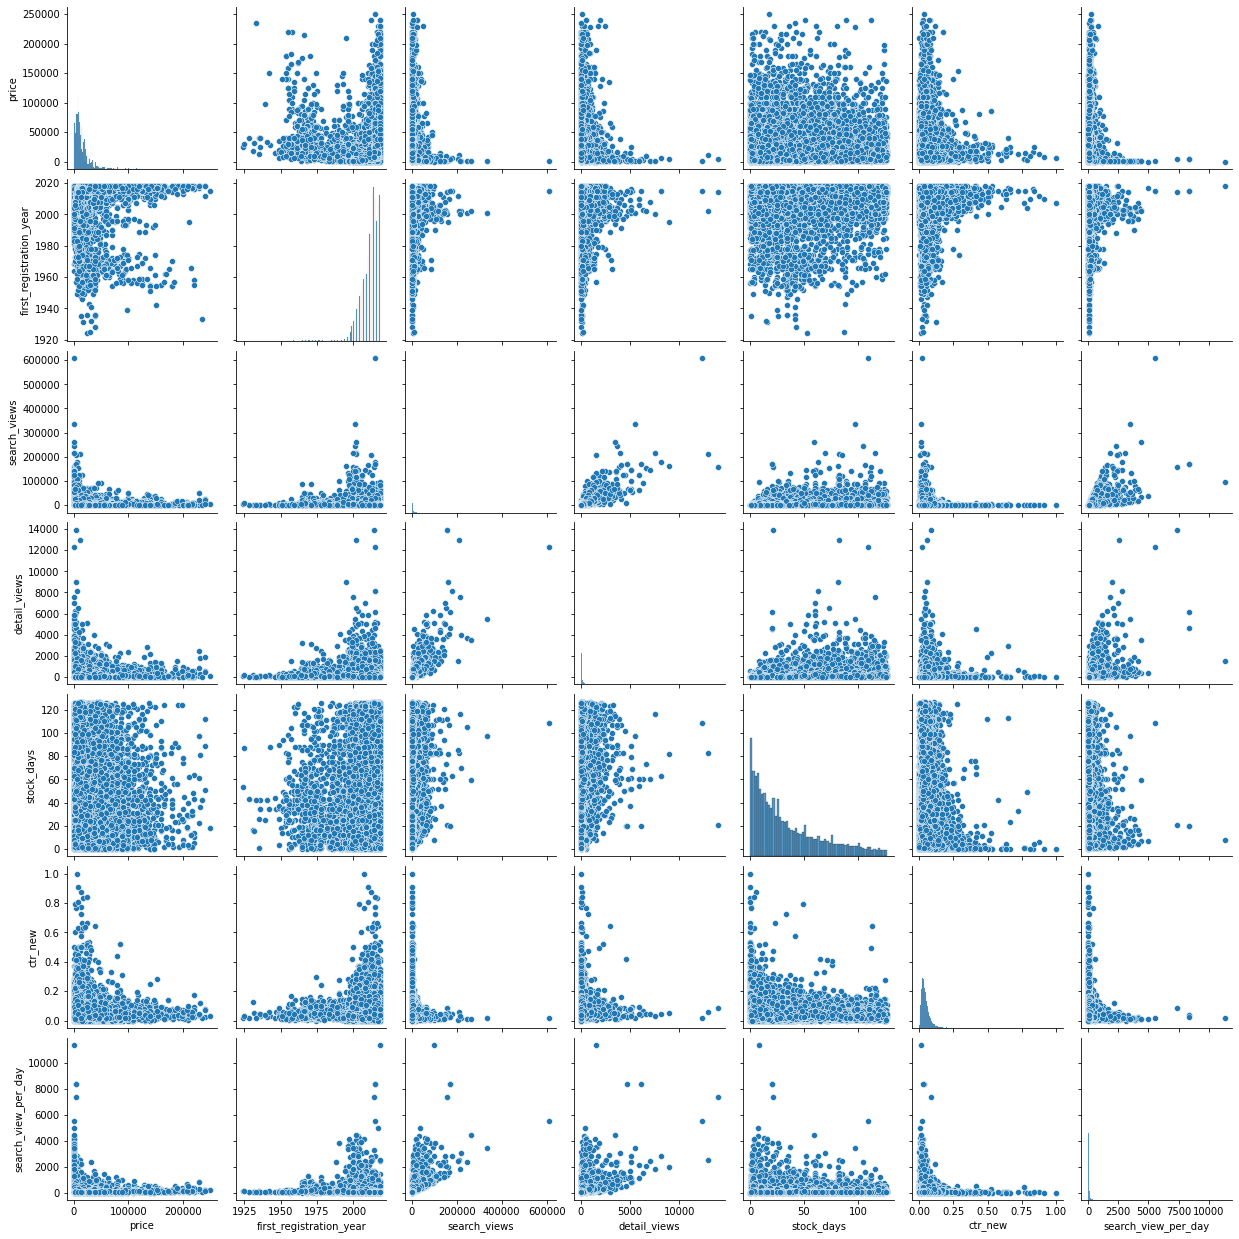

In [15]:
sns.pairplot(df_cleaned[["price","first_registration_year","search_views","detail_views","stock_days","ctr_new","search_view_per_day"]])

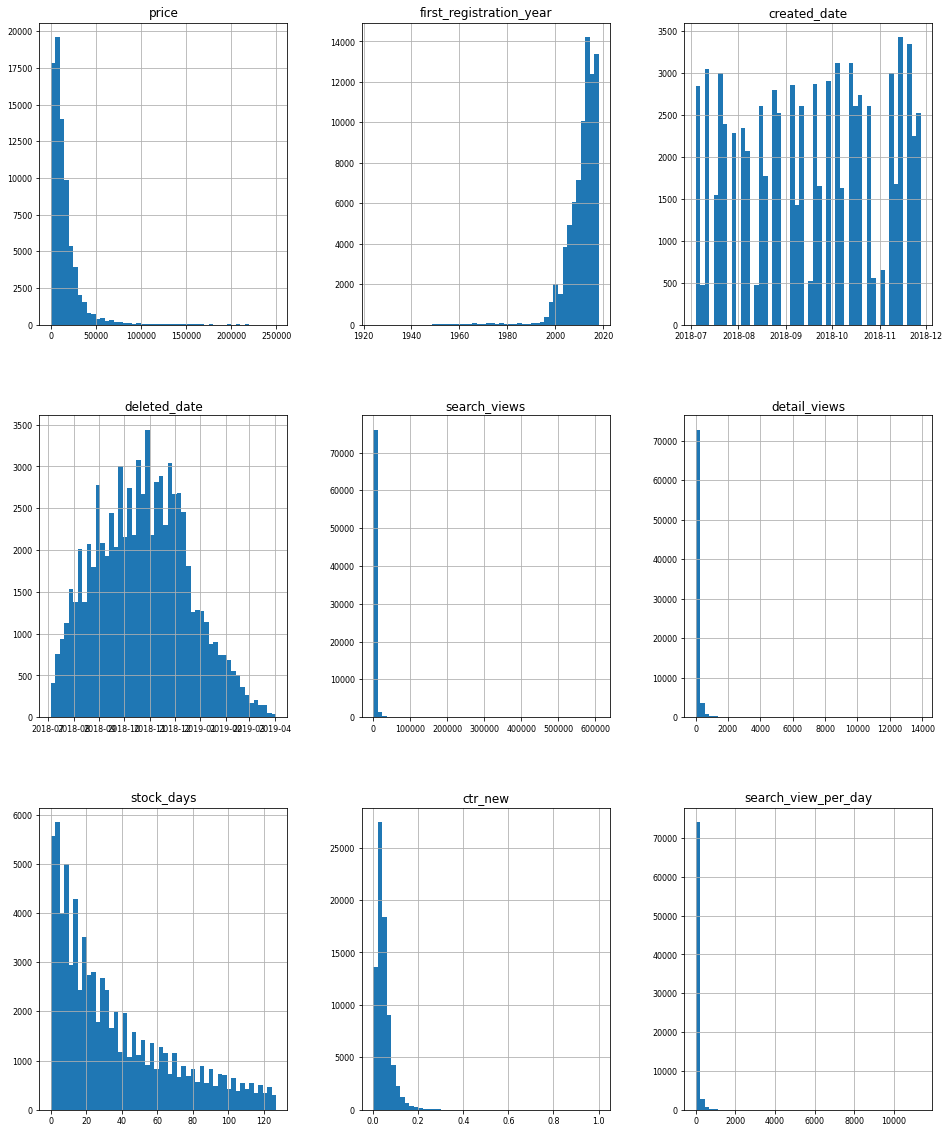

In [16]:
df_cleaned[["price","first_zip_digit","first_registration_year","created_date","deleted_date","search_views","detail_views","stock_days","ctr_new","search_view_per_day"]].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations


Search_views and detail_views are highly right-skewed. Log transformation might be useful which results in a more symmetric, bell-shaped distribution that resembles a normal distribution.

By transforming a right-skewed distribution into a more normal distribution, I can apply statistical methods that would require data to be in normal distribution.



In [17]:
df_cleaned["log_search_views"] = np.log(df_cleaned.search_views+1)
df_cleaned["log_detail_views"] = np.log(df_cleaned.detail_views+1)
df_cleaned["log_price"] = np.log(df_cleaned.price)

array([[<AxesSubplot:title={'center':'log_search_views'}>,
        <AxesSubplot:title={'center':'log_detail_views'}>],
       [<AxesSubplot:title={'center':'log_price'}>, <AxesSubplot:>]],
      dtype=object)

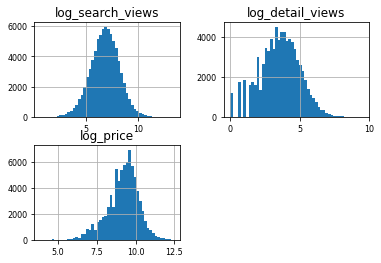

In [18]:
df_cleaned[["log_search_views","log_detail_views","log_price"]].hist(bins=50, xlabelsize=8, ylabelsize=8)

In [19]:
df_cleaned.stock_days.value_counts(normalize=True)[:25]

1     0.030014
2     0.027453
7     0.026723
4     0.025660
3     0.025391
6     0.024508
5     0.023791
8     0.023432
9     0.020833
21    0.020026
10    0.019655
14    0.019629
11    0.019450
13    0.018451
12    0.018131
15    0.016863
16    0.015775
18    0.015673
17    0.015391
20    0.015365
22    0.015096
19    0.013970
0     0.013765
23    0.012151
28    0.011985
Name: stock_days, dtype: float64

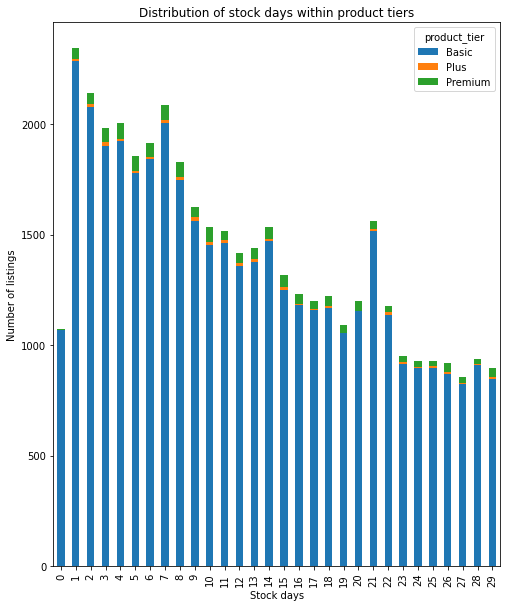

In [20]:
grouped = df_cleaned[df_cleaned.stock_days<30].groupby(["stock_days","product_tier"])["article_id"].count()

# Reshape the data to have product_tier as columns
stacked = grouped.unstack()

# Plot the stacked bar plot
stacked.plot(kind='bar', stacked=True,figsize=(8, 10))

# Set the plot title and axis labels
plt.title('Distribution of stock days within product tiers')
plt.xlabel('Stock days')
plt.ylabel('Number of listings')

# Show the plot
plt.show()



1.   ~ 20% of the listings are deleted within 1 week period.
2.   Listing deletions are peaking on 1st, 7th, 14th, 21st day. Are there weekly boosts? 


In [21]:
#I'll look at search_views and price outliers
df_cleaned.sort_values(by="search_views",ascending = False)

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr_new,search_view_per_day,log_search_views,log_detail_views,log_price
74838,359753805,Basic,Renault,199,7,2015,2018-10-04,2019-01-21,608754.0,12286.0,109,0.020182,5559.397260,13.319171,9.416297,5.293305
52777,349571884,Premium,Volvo,750,2,2001,2018-07-16,2018-10-21,335376.0,5490.0,97,0.016370,3439.753846,12.723011,8.610866,6.620073
72007,348760265,Premium,Peugeot,649,3,2002,2018-07-12,2018-09-09,262007.0,3473.0,59,0.013255,4403.478992,12.476130,8.153062,6.475433
19558,348760278,Basic,Volvo,999,3,2001,2018-07-12,2018-10-25,246870.0,3667.0,105,0.014854,2340.000000,12.416621,8.207402,6.906755
19104,363589544,Premium,Renault,700,2,2002,2018-11-16,2019-01-25,216946.0,3944.0,70,0.018180,3077.248227,12.287408,8.280204,6.551080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33576,360447854,Basic,Fiat,12895,5,2017,2018-10-12,2018-10-12,1.0,0.0,0,0.000000,0.000000,0.693147,0.000000,9.464595
23989,360447852,Basic,Fiat,11395,5,2017,2018-10-12,2018-10-12,1.0,0.0,0,0.000000,0.000000,0.693147,0.000000,9.340930
48375,360446208,Basic,Volkswagen,8445,6,2014,2018-10-12,2018-10-12,1.0,0.0,0,0.000000,0.000000,0.693147,0.000000,9.041330
62101,355653964,Basic,Ford,19900,3,2017,2018-08-28,2018-08-28,1.0,0.0,0,0.000000,0.000000,0.693147,0.000000,9.898475


Highest search - 608K is is quite far from the second highest search - 335K. 2015 model Renault, in basic product tier for 199 Eur for 109 days seems to be reviewed for further analysis. If I had the chance to talk to business stakeholders, I'd validate this data. I'm skeptical about it right now 

In [22]:
#I'll look at search_views and price outliers
df_cleaned.sort_values(by="price",ascending = False)

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr_new,search_view_per_day,log_search_views,log_detail_views,log_price
64204,359208125,Basic,Ferrari,249888,5,2015,2018-09-28,2018-10-16,3842.0,128.0,18,0.033316,207.675676,8.254009,4.859812,12.428768
51965,358547874,Basic,Bentley,239800,1,2018,2018-09-20,2018-12-18,20950.0,567.0,89,0.027064,234.078212,9.949942,6.342121,12.387561
64331,359751856,Basic,Ferrari,239500,6,2012,2018-10-04,2018-11-24,6928.0,497.0,51,0.071738,134.524272,8.843471,6.210600,12.386309
34129,348703099,Basic,Ferrari,239500,1,2018,2018-07-12,2018-11-01,23844.0,1905.0,112,0.079894,211.946667,10.079330,7.552762,12.386309
63236,350219482,Basic,Others,235000,7,1933,2018-07-20,2018-08-30,2079.0,42.0,42,0.020202,48.917647,7.640123,3.761200,12.367341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17476,350213389,Basic,Volvo,50,9,2007,2018-07-20,2018-07-28,270.0,2.0,8,0.007407,31.764706,5.602119,1.098612,3.912023
20941,359208296,Basic,Volvo,50,9,2015,2018-09-28,2018-10-04,424.0,14.0,7,0.033019,56.533333,6.052089,2.708050,3.912023
78183,360087650,Basic,BMW,50,5,2002,2018-10-08,2018-10-19,172.0,8.0,11,0.046512,14.956522,5.153292,2.197225,3.912023
53367,359208073,Basic,Fiat,50,2,2006,2018-09-28,2018-09-30,23.0,0.0,2,0.000000,9.200000,3.178054,0.000000,3.912023


I also see some articles with 50 Eur price. My initial data description showed me that bottom 1% of the cars were up to 695 Eur. 
Today, min price bracket is 500 Eur in the website; which is ~430 Eur of 2018 and cars in that range seem outliers to me.
I'll accept 500 Eur as base for my analysis and delete values below this price. 

In [23]:
df_cleaned_normal = df_cleaned[df_cleaned.price>500]

In [24]:
df_cleaned_normal.created_date.dt.month.value_counts()

#Finding--> Oct - November is the peak period

11    16759
10    16233
7     15442
9     14733
8     14476
Name: created_date, dtype: int64

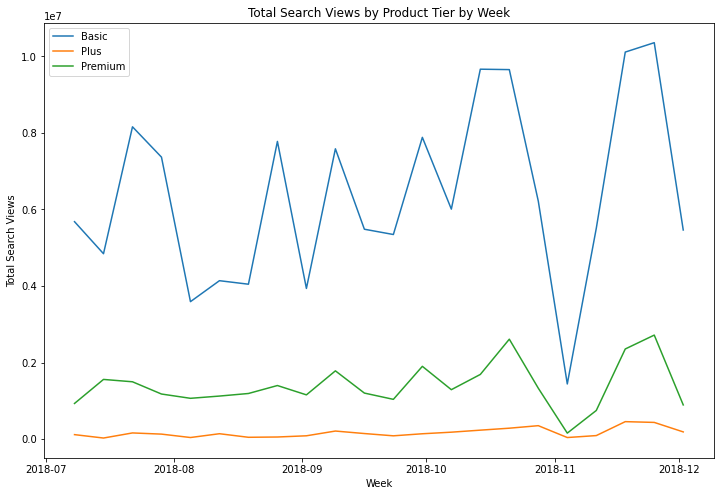

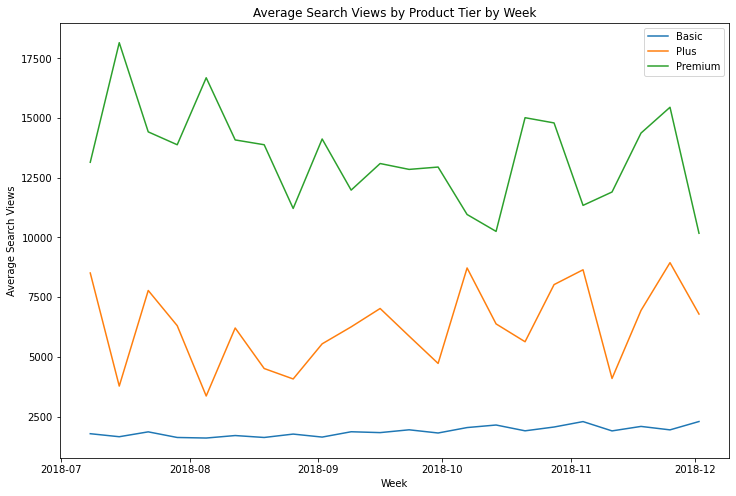

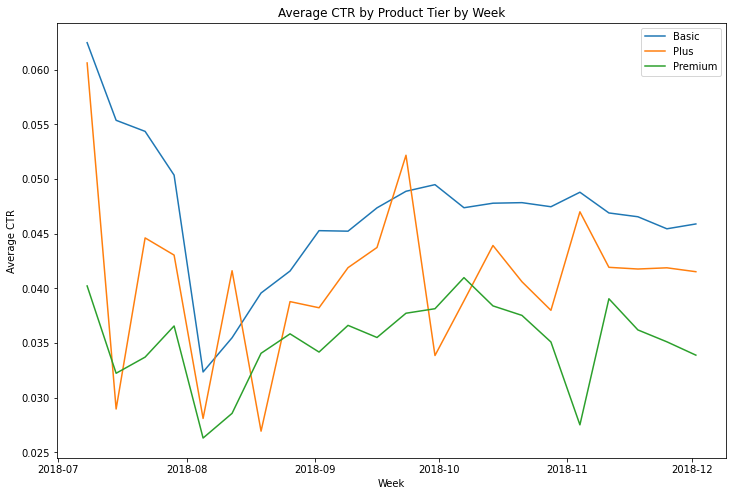

In [43]:
# Set the created_date column as the index
df_plot = df_cleaned_normal.copy()
df_plot.set_index('created_date', inplace=True)

# Resample the data by week and by product tier
weekly_product_tier_df = df_plot.groupby(['product_tier', pd.Grouper(freq='W')]).agg({
    'search_views': ['sum', 'mean'],
    'ctr_new': ['mean'],
    'search_view_per_day': ['mean']
}).reset_index()


# Plot the total search views by product tier by week
fig, ax = plt.subplots(figsize=(12,8))
for product_tier in ['Basic', 'Plus', 'Premium']:
    data = weekly_product_tier_df[weekly_product_tier_df['product_tier'] == product_tier]
    ax.plot(data['created_date'], data[('search_views', 'sum')], label=product_tier)
ax.set_xlabel('Week')
ax.set_ylabel('Total Search Views')
ax.set_title('Total Search Views by Product Tier by Week')
ax.legend()


# Plot the average search views by product tier by week
fig, ax = plt.subplots(figsize=(12,8))
for product_tier in ['Basic', 'Plus', 'Premium']:
    data = weekly_product_tier_df[weekly_product_tier_df['product_tier'] == product_tier]
    ax.plot(data['created_date'], data[('search_views', 'mean')], label=product_tier)
ax.set_xlabel('Week')
ax.set_ylabel('Average Search Views')
ax.set_title('Average Search Views by Product Tier by Week')
ax.legend()


# Plot the average search views by product tier by week
fig, ax = plt.subplots(figsize=(12,8))
for product_tier in ['Basic', 'Plus', 'Premium']:
    data = weekly_product_tier_df[weekly_product_tier_df['product_tier'] == product_tier]
    ax.plot(data['created_date'], data[('ctr_new', 'mean')], label=product_tier)
ax.set_xlabel('Week')
ax.set_ylabel('Average CTR')
ax.set_title('Average CTR by Product Tier by Week')
ax.legend()
plt.show()

Inıtial findings from the plots:
1. Oct - November is peak period for listing creation
2. CTR and Search View trends are generally aligned within product tiers over the observed time period. However, I'd further investigate the outlier weeks to understand what happened on those periods to understand sharp declines/increases.


In [26]:
corr_metrics = ["price","log_search_views","ctr_new","log_detail_views","stock_days","search_view_per_day"]

for corr_metric in corr_metrics:
  corr_df = df_cleaned_normal.corrwith(df_cleaned_normal[corr_metric])
  corr_df = corr_df.sort_values(ascending=False)
  print(f'metric is: {corr_metric}')
  print(corr_df)

metric is: price
price                      1.000000
log_price                  0.781292
first_registration_year    0.307121
stock_days                 0.082835
log_search_views           0.040671
log_detail_views           0.040665
detail_views               0.034453
article_id                 0.009778
search_views               0.009526
ctr_new                    0.003795
search_view_per_day       -0.050823
dtype: float64
metric is: log_search_views
log_search_views           1.000000
log_detail_views           0.883564
stock_days                 0.597435
search_views               0.545210
detail_views               0.532418
search_view_per_day        0.393340
article_id                 0.089584
price                      0.040671
log_price                 -0.058653
ctr_new                   -0.124970
first_registration_year   -0.170931
dtype: float64
metric is: ctr_new
ctr_new                    1.000000
log_detail_views           0.276770
detail_views               0.109250
log_pr

As the first_registration_year increases, search_view_per_day slightly decreases. Are users more likely to search older cars?

# Business case


On Top Products; **may primarily increase impressions**, and also **potentially increase clicks** due to their prominent placement and design. **However, the impact on click-through rate (CTR) is less clear and may vary based on several factors**.

On one hand, having a prominent and visually appealing listing **may lead to an increase in clicks and therefore a higher CTR**. However, on the other hand, if the listing **is not relevant or attractive to the user, they may quickly exit the page without clicking, resulting in a lower CTR**.

Additionally, if the On Top Products increase the visibility and placement of a listing, it may also l**ead to increased competition from other sellers, which could potentially lead to a lower CTR** as buyers have more options to choose from. For example, if a buyer sees several similar listings for a specific type of vehicle all appearing at the top of the search results, they may spend more time comparing listings and be less likely to click on any single listing, resulting in a lower CTR.

Overall, it's difficult to assume the exact impact of On Top Products on CTR without considering **specific details of the listings**, **the market, and user behavior**. However, it is likely that these premium features can increase impressions and clicks, and the impact on CTR may vary.


I also think "stock days" is a performance indicator, however it can change depending on the context.
1. Are sellers able to **hold their listings longer** with on top products?
2. If **yes, it can increase** for on top products. If no, **I can expect lower stock days** for on top products.



I'll try to analyze these features






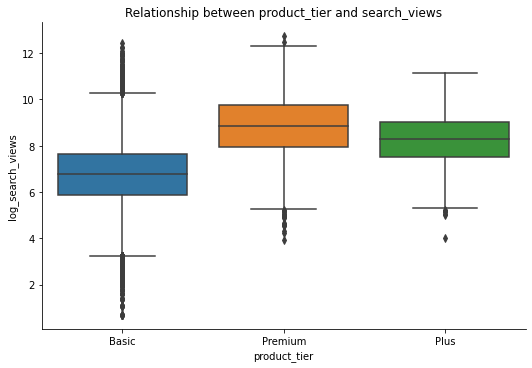

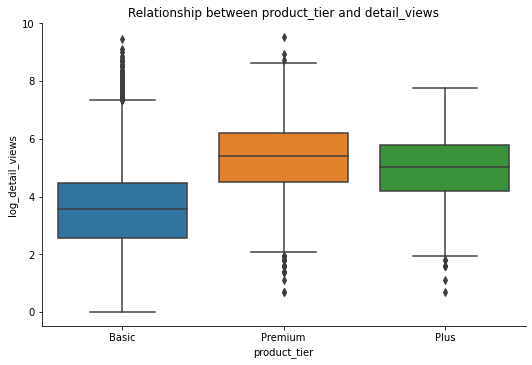

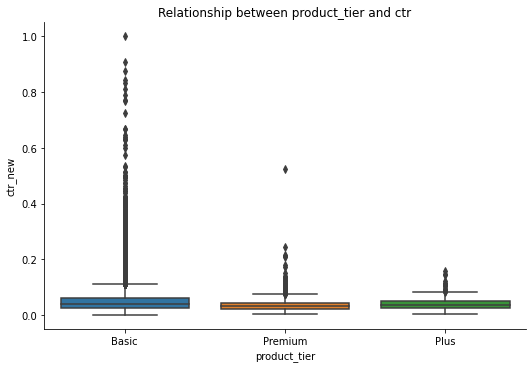

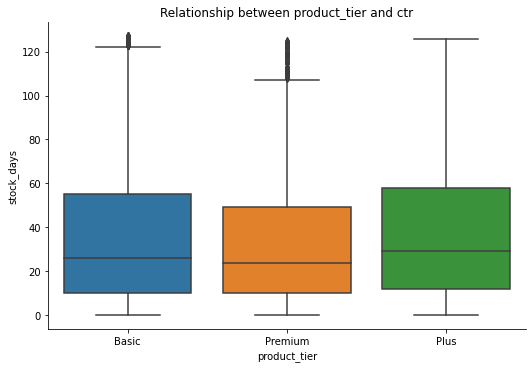

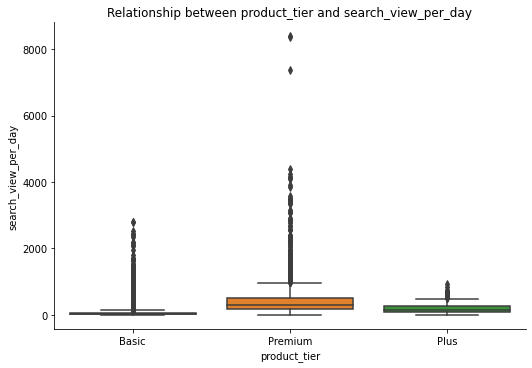

In [27]:
sns.catplot(x="product_tier", y="log_search_views", data=df_cleaned_normal, kind="box", aspect=1.5)
plt.title("Relationship between product_tier and search_views")

sns.catplot(x="product_tier", y="log_detail_views", data=df_cleaned_normal, kind="box", aspect=1.5)
plt.title("Relationship between product_tier and detail_views")

sns.catplot(x="product_tier", y="ctr_new", data=df_cleaned_normal, kind="box", aspect=1.5)
plt.title("Relationship between product_tier and ctr")

sns.catplot(x="product_tier", y="stock_days", data=df_cleaned_normal, kind="box", aspect=1.5)
plt.title("Relationship between product_tier and ctr")

sns.catplot(x="product_tier", y="search_view_per_day", data=df_cleaned_normal, kind="box", aspect=1.5)
plt.title("Relationship between product_tier and search_view_per_day")

plt.show()

In [28]:
metrics = ["price","search_views","detail_views","ctr_new","search_view_per_day","stock_days"]


print("Overall Distribution")
print(df_cleaned_normal.product_tier.value_counts())
print(df_cleaned_normal.product_tier.value_counts(normalize = True))

for metric in metrics:
  print(f"\n{metric.upper()}\n")
  print(df_cleaned_normal.groupby("product_tier")[metric].mean().reset_index())

Overall Distribution
Basic      74774
Premium     2304
Plus         565
Name: product_tier, dtype: int64
Basic      0.963049
Premium    0.029674
Plus       0.007277
Name: product_tier, dtype: float64

PRICE

  product_tier         price
0        Basic  15160.649597
1         Plus  12960.612389
2      Premium  14704.415799

SEARCH_VIEWS

  product_tier  search_views
0        Basic   1876.079693
1         Plus   6549.746903
2      Premium  13395.109809

DETAIL_VIEWS

  product_tier  detail_views
0        Basic     81.731725
1         Plus    245.483186
2      Premium    400.264323

CTR_NEW

  product_tier   ctr_new
0        Basic  0.047292
1         Plus  0.041046
2      Premium  0.035857

SEARCH_VIEW_PER_DAY

  product_tier  search_view_per_day
0        Basic            58.803473
1         Plus           195.028064
2      Premium           445.451799

STOCK_DAYS

  product_tier  stock_days
0        Basic   36.132974
1         Plus   39.069027
2      Premium   33.399740


Findings:
1.  Majority of articles are Basic (~ 96.3%), with very few(~ 0.3%) are the Premium option and least common as Plus (~ 0.7%)
2. Average price for Premium is lower than Basic, and Plus is the lowest. Is this aligned with our product strategy?


In [29]:
# See top 7 cars in terms of listing count 
top_7_cars = df.groupby('make_name').size().reset_index(name='count') \
                .sort_values('count', ascending=False).head(7)['make_name'].tolist()
top_7_cars

['Volkswagen', 'Renault', 'Peugeot', 'Opel', 'Ford', 'Mercedes-Benz', 'BMW']

In [30]:
# Select top makes defined in the website
top_makes = ['Volkswagen',
 'Renault',
 'Opel',
 'Ford',
 'Mercedes-Benz',
 'BMW',
 'Audi']

# Grop brands as top and other 
df_cleaned_normal.loc[:, "make_type"] = ["top_make" if car in top_makes else "other_make" for car in df_cleaned_normal.make_name]


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [31]:
metrics = ["search_views","detail_views","ctr_new","search_view_per_day","stock_days"]


print("Overall Distribution")
print(df_cleaned_normal.make_type.value_counts())
print(df_cleaned_normal.make_type.value_counts(normalize = True))

for metric in metrics:
  print(f"\n{metric.upper()}\n")
  print(df_cleaned_normal.groupby("make_type")[metric].mean().reset_index())

Overall Distribution
top_make      39079
other_make    38564
Name: make_type, dtype: int64
top_make      0.503316
other_make    0.496684
Name: make_type, dtype: float64

SEARCH_VIEWS

    make_type  search_views
0  other_make   2161.911990
1    top_make   2340.718775

DETAIL_VIEWS

    make_type  detail_views
0  other_make     87.161446
1    top_make     97.520945

CTR_NEW

    make_type   ctr_new
0  other_make  0.045533
1    top_make  0.048264

SEARCH_VIEW_PER_DAY

    make_type  search_view_per_day
0  other_make            68.455526
1    top_make            74.043957

STOCK_DAYS

    make_type  stock_days
0  other_make   36.297920
1    top_make   35.851506


**Top_make cars have higher average of search_views,detail_views,CTR, search/day and lower stock_days**. For now, I'm not going to test whether this difference is significant or not

In [32]:
metrics = ["search_views","detail_views","ctr_new","search_view_per_day","stock_days"]


print("Overall Distribution")
print(df_cleaned_normal.first_zip_digit.value_counts())
print(df_cleaned_normal.first_zip_digit.value_counts(normalize = True))

for metric in metrics:
  print(f"\n{metric.upper()}\n")
  print(df_cleaned_normal.groupby("first_zip_digit")[metric].mean().reset_index())

Overall Distribution
3    13212
5    12037
7    10879
2     9659
1     7663
6     7198
4     6719
8     6138
9     4138
Name: first_zip_digit, dtype: int64
3    0.170163
5    0.155030
7    0.140116
2    0.124403
1    0.098695
6    0.092706
4    0.086537
8    0.079054
9    0.053295
Name: first_zip_digit, dtype: float64

SEARCH_VIEWS

  first_zip_digit  search_views
0               1   2123.039802
1               2   2673.582255
2               3   2307.490463
3               4   2009.961453
4               5   2215.880037
5               6   2190.263823
6               7   2289.439562
7               8   2237.950472
8               9   1855.732963

DETAIL_VIEWS

  first_zip_digit  detail_views
0               1     91.093827
1               2     98.318252
2               3     93.989631
3               4     86.251228
4               5     93.303315
5               6     91.193109
6               7     97.080706
7               8     90.798469
8               9     74.995650

CTR_NEW



In [33]:
city_listing_counts = df_cleaned_normal.groupby(['first_zip_digit','product_tier'])['article_id'].count().reset_index()

city_wide = city_listing_counts.pivot(index="first_zip_digit", columns="product_tier", values="article_id")

city_wide["premium_basic_ratio"] = city_wide["Premium"] / city_wide["Basic"]
city_wide

product_tier,Basic,Plus,Premium,premium_basic_ratio
first_zip_digit,,,,
1,7468,54,141,0.018881
2,8858,73,728,0.082186
3,12802,65,345,0.026949
4,6587,27,105,0.015940
5,11633,131,273,0.023468
6,7032,60,106,0.015074
7,10479,97,303,0.028915
8,5836,49,253,0.043352
9,4079,9,50,0.012258


Region 2 is the highest region in terms of Premium/Basic listing ratio

In [34]:
df_city_summary = df_cleaned_normal.groupby(["first_zip_digit","product_tier"])["search_views"].mean().reset_index()
df_wide = df_city_summary.pivot(index="first_zip_digit", columns="product_tier", values="search_views")

df_wide["basic_premium_ratio"] = df_wide["Premium"] / df_wide["Basic"]
df_wide

product_tier,Basic,Plus,Premium,basic_premium_ratio
first_zip_digit,,,,
1,1897.136449,7150.222222,12162.602837,6.411032
2,1759.254798,6409.054795,13424.163462,7.630596
3,1959.749258,7107.784615,14306.805797,7.300325
4,1821.090785,5839.666667,12873.666667,7.069206
5,1934.082008,4868.251908,12951.029304,6.696215
6,1924.934443,8094.550000,16450.066038,8.545780
7,1903.056971,6666.670103,14250.864686,7.488407
8,1787.087560,7748.836735,11570.766798,6.474650
9,1725.805835,8575.888889,11245.560000,6.516121


In terms of average search views, on Region 6 Premium is the most effective against Basic.

When we look at the average search views in terms of city and product_tier, the proportion(trends) are still similar. But I'll not test them


# Hypothesis testing

I'll try to test the analyze (product_tier) mean differences with independent t-test, if the observed differences have p-values < 0.05 I'll be confident to say that the differences are significant.

In [35]:
##creating a function to analyze mean,std and pvalue between each products, depending on dataframe and metric

def analyze_on_top_products(df, metric):
    # Split the data into three groups based on the On Top Products
    group1 = df[df['product_tier'] == 'Basic']
    group2 = df[df['product_tier'] == 'Plus']
    group3 = df[df['product_tier'] == 'Premium']

    # Calculate the mean and standard deviation of the selected metric for each group
    mean1 = group1[metric].mean()
    mean2 = group2[metric].mean()
    mean3 = group3[metric].mean()
    std1 = group1[metric].std()
    std2 = group2[metric].std()
    std3 = group3[metric].std()

    # Perform pairwise t-tests to compare the selected metric of the three groups
    t_stat1, p_val1 = ttest_ind(group1[metric], group2[metric], equal_var=False)
    t_stat2, p_val2 = ttest_ind(group1[metric], group3[metric], equal_var=False)
    t_stat3, p_val3 = ttest_ind(group2[metric], group3[metric], equal_var=False)

    # Print the results
    print('Mean and standard deviation of {} for group 1 (Basic): {:.4f}, {:.4f}'.format(metric, mean1, std1))
    print('Mean and standard deviation of {} for group 2 (Plus): {:.4f}, {:.4f}'.format(metric, mean2, std2))
    print('Mean and standard deviation of {} for group 3 (Premium): {:.4f}, {:.4f}'.format(metric, mean3, std3))
    print('p-value for Basic vs Plus: {:.4f}'.format(p_val1))
    print('p-value for Basic vs Premium:{:.4f}'.format(p_val2))
    print('p-value for Plus vs Premium: {:.4f}'.format(p_val3))




In [36]:
performance_ind = ["search_views","detail_views","ctr_new","search_view_per_day","stock_days"]

for metric in performance_ind:
  analyze_on_top_products(df_cleaned_normal,metric)
  print('\n')

Mean and standard deviation of search_views for group 1 (Basic): 1876.0797, 4179.9234
Mean and standard deviation of search_views for group 2 (Plus): 6549.7469, 7641.8573
Mean and standard deviation of search_views for group 3 (Premium): 13395.1098, 19897.7146
p-value for Basic vs Plus: 0.0000
p-value for Basic vs Premium:0.0000
p-value for Plus vs Premium: 0.0000


Mean and standard deviation of detail_views for group 1 (Basic): 81.7317, 186.3927
Mean and standard deviation of detail_views for group 2 (Plus): 245.4832, 280.5873
Mean and standard deviation of detail_views for group 3 (Premium): 400.2643, 612.0934
p-value for Basic vs Plus: 0.0000
p-value for Basic vs Premium:0.0000
p-value for Plus vs Premium: 0.0000


Mean and standard deviation of ctr_new for group 1 (Basic): 0.0473, 0.0384
Mean and standard deviation of ctr_new for group 2 (Plus): 0.0410, 0.0207
Mean and standard deviation of ctr_new for group 3 (Premium): 0.0359, 0.0227
p-value for Basic vs Plus: 0.0000
p-value for

The first set of results shows the mean and standard deviation of the number of **search views** for each group. The results indicate that the **Premium group had the highest number of search views, followed by the Plus group and then the Basic group**. The differences between the groups were statistically **significant**, as indicated by the p-values.

The second set of results shows the mean and standard deviation of the number of **detail views** for each group. The results indicate that the **Premium group had the highest number of detail views, followed by the Plus group and then the Basic group**. The differences between the groups were **statistically significant**, as indicated by the p-values.

The third set of results shows the mean and standard deviation of the click-through rate (CTR) for each group. The results indicate that the **Basic group had the highest CTR, followed by the Plus group and then the Premium group**. The differences between the groups were **statistically significant**, as indicated by the p-values.

The fourth set of results shows the mean and standard deviation of the **number of search views per day** for each group. This metric is a measure of the rate at which a listing is viewed by potential buyers. The results indicate that the **Premium group had the highest search views per day, followed by the Plus group and then the Basic group**. The differences between the groups were statistically significant, as indicated by the p-values.

The final set of results shows the mean and standard deviation of the number of days that a **listing is open** for each group. **The results indicate that the Premium group had the shortest stock days, followed by the Basic group and then the Plus group**. The differences between the groups were statistically significant, as indicated by the p-values.


# Interesting fact: Why the "Premium CTR" can be the lowest?
1. Premium listings **may attract more casual or less serious buyers** who are browsing and may not be as likely to click through to view the details of the listing.

2. **Premium listings may be priced higher** than Basic listings, which could deter some buyers from clicking through. **But this is not the case** in our dataset.

3. Since Premium listings are at the top of the search results**, buyers may be more likely to click on the first few listings they see, which could result in a lower click-through rate for Premium listings that are further down** the list.

I'll also filter my dataset to test the differences **within top_makes** and **other_makes**

In [37]:
#analyze for top_make

for metric in performance_ind:
  analyze_on_top_products(df_cleaned_normal[df_cleaned_normal.make_type=="top_make"],metric)
  print('\n')

Mean and standard deviation of search_views for group 1 (Basic): 1915.9422, 4355.3000
Mean and standard deviation of search_views for group 2 (Plus): 6132.5153, 7188.0844
Mean and standard deviation of search_views for group 3 (Premium): 14282.3440, 20163.6557
p-value for Basic vs Plus: 0.0000
p-value for Basic vs Premium:0.0000
p-value for Plus vs Premium: 0.0000


Mean and standard deviation of detail_views for group 1 (Basic): 85.2612, 193.1718
Mean and standard deviation of detail_views for group 2 (Plus): 241.8206, 279.7453
Mean and standard deviation of detail_views for group 3 (Premium): 434.8859, 696.1509
p-value for Basic vs Plus: 0.0000
p-value for Basic vs Premium:0.0000
p-value for Plus vs Premium: 0.0000


Mean and standard deviation of ctr_new for group 1 (Basic): 0.0487, 0.0409
Mean and standard deviation of ctr_new for group 2 (Plus): 0.0427, 0.0213
Mean and standard deviation of ctr_new for group 3 (Premium): 0.0360, 0.0246
p-value for Basic vs Plus: 0.0000
p-value for

Results are aligned with the initial dataset, however only the differences in stock_days means are not significant, within top_makes

In [38]:
#analyze for other_make

for metric in performance_ind:
  analyze_on_top_products(df_cleaned_normal[df_cleaned_normal.make_type=="other_make"],metric)
  print('\n')

Mean and standard deviation of search_views for group 1 (Basic): 1835.8379, 3994.7322
Mean and standard deviation of search_views for group 2 (Plus): 6910.5215, 8007.8441
Mean and standard deviation of search_views for group 3 (Premium): 12337.3511, 19532.8758
p-value for Basic vs Plus: 0.0000
p-value for Basic vs Premium:0.0000
p-value for Plus vs Premium: 0.0000


Mean and standard deviation of detail_views for group 1 (Basic): 78.1687, 179.2214
Mean and standard deviation of detail_views for group 2 (Plus): 248.6502, 281.7374
Mean and standard deviation of detail_views for group 3 (Premium): 358.9886, 490.6690
p-value for Basic vs Plus: 0.0000
p-value for Basic vs Premium:0.0000
p-value for Plus vs Premium: 0.0000


Mean and standard deviation of ctr_new for group 1 (Basic): 0.0459, 0.0356
Mean and standard deviation of ctr_new for group 2 (Plus): 0.0396, 0.0201
Mean and standard deviation of ctr_new for group 3 (Premium): 0.0357, 0.0203
p-value for Basic vs Plus: 0.0000
p-value for

Results are aligned with the initial dataset, however only the differences in stock_days means are partially not significant (between basic and plus, it is not significany), within other_makes

#Regression Analysis, OLS

In [39]:
#create a function that takes a df and understands the effects the x features on y variable
def run_linear_regression(df, features, y_variable):
    # Define the predictor variables and the response variable
    X = df[features]
    y = df[y_variable]

    # Encode the categorical variables using one-hot encoding
    X = pd.get_dummies(X,drop_first=True)

    # Add an intercept term to the predictor variables
    X = sm.add_constant(X)

    # Fit a linear regression model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model
    print(model.summary())

In [40]:
features_list = ['product_tier', 'make_type', 'first_zip_digit', 'price', 'first_registration_year']
y_list = ['log_search_views', 'ctr_new', 'search_views_per_day']


for y in ['log_search_views', 'ctr_new', 'search_view_per_day']:
    print('\n')
    print(f"Running linear regression for {y}")
    print('\n')
    run_linear_regression(df_cleaned_normal,features_list,y)



Running linear regression for log_search_views


                            OLS Regression Results                            
Dep. Variable:       log_search_views   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     743.6
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        07:23:34   Log-Likelihood:            -1.2951e+05
No. Observations:               77643   AIC:                         2.590e+05
Df Residuals:                   77629   BIC:                         2.592e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

Features with p_val< 0.05 show that they are statistically significant in explaining the variation in y variables.


Most of the first_zip_digit variables are insignicant. For the sake of simplicity, I'll remove this feature



In [41]:
##remove first_zip_digit

features_list = ['product_tier', 'make_type','price', 'first_registration_year']
y_list = ['log_search_views', 'ctr_new', 'search_views_per_day']


for y in ['log_search_views', 'ctr_new', 'search_view_per_day']:
    print('\n')
    print(f"Running linear regression for {y}")
    print('\n')
    run_linear_regression(df_cleaned_normal,features_list,y)



Running linear regression for log_search_views


                            OLS Regression Results                            
Dep. Variable:       log_search_views   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     1921.
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        07:23:35   Log-Likelihood:            -1.2953e+05
No. Observations:               77643   AIC:                         2.591e+05
Df Residuals:                   77637   BIC:                         2.591e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

OLS also supports our initial findings.
Plus-Premium has higher effect on search views, search view per day; but they've lower CTR

In [42]:
#let's build the same model filtering for top brands

df_top = df_cleaned_normal[df_cleaned_normal.make_type=="top_make"]
df_other = df_cleaned_normal[df_cleaned_normal.make_type=="other_make"]


features_list = ['product_tier', 'make_type','price', 'first_registration_year']
y_list = ['log_search_views', 'ctr_new', 'search_views_per_day']


for y in ['log_search_views', 'ctr_new', 'search_view_per_day']:
    print('\n')
    print(f"Running linear regression for {y}")
    print('\n')
    run_linear_regression(df_top,features_list,y)


for y in ['log_search_views', 'ctr_new', 'search_view_per_day']:
    print('\n')
    print(f"Running linear regression for {y}")
    print('\n')
    run_linear_regression(df_other,features_list,y)



Running linear regression for log_search_views


                            OLS Regression Results                            
Dep. Variable:       log_search_views   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     1372.
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        07:23:35   Log-Likelihood:                -65582.
No. Observations:               39079   AIC:                         1.312e+05
Df Residuals:                   39074   BIC:                         1.312e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

The case still similar if the filter the dataset for top_makes and other_makes

# For further analysis




*   Where the premium listings are located; in terms of page_rank and rank_within_page
*   How these metrics vary among search pages
*   Other car attributes like gas, gear, km, new or used etc.
*   Analyzing stock "hours" instead of days
*   Path to purchase, for each user whey they drop in the search funnel; or where they came from (for example what they've filtered)
*   Seller analysis; how their paid vs basic listings change when they switched from basic to on-top products










# Conclusion

Based on the tests conducted on the product tier's performance on **search views, detail_views, CTR, and search per day**, the following conclusions can be drawn:

The Plus-Premium product tier has a **positive effect on search views, detail_views and search views per day compared to the Basic product tier**.

However, the Plus-Premium product tier has a **lower CTR compared to the Basic** product tier.

These findings suggest that the Plus-Premium product tier may be more suitable for products that require higher visibility and engagement, while the Plus product tier may be more suitable for products that require higher click-through rates.


Possible actions:
Promote search/click benefit for customers
Improve design&targeting for premium-plus products


**Promote visibility benefit for these products**: Promotion for paid listings like "5/7 times higher impression and clicks & faster sell"

**Personalized search**: The team can consider targeted advertising to increase the visibility of premium-plus products to potential buyers who are more likely to be interested in them. This may help improve the CTR for these products.

**Improve the product description**: The team can focus on creating more compelling and informative product descriptions for premium-plus products, which may help attract more potential buyers and encourage them to click on the ad.

**Re-consider premium listing page position**: If there are many premium listings that are going down in the ranking, it could be worth considering a change in the position or visibility of premium listings on the website. This could include increasing the number of premium listings shown at the top of the search results, or offering additional exposure for premium listings through targeted email campaigns or advertising

**Optimize the product images**: High-quality and eye-catching images can make a big difference in attracting buyers and increasing CTR. The team can consider optimizing the product images for premium-plus products to make them more appealing and attention-grabbing.


